In [41]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_color_codes("colorblind")

results_raw = pd.read_parquet("results/performance.parquet")
ecmo_size = torch.load("cache/ihmtensors/X_ecmo.pt").shape[0]

results_raw['Fine Tuning Size'] = results_raw['Fine Tuning Size'].apply(lambda x: ecmo_size if x == 0 else x)

pretty_names_map = {
    'combined': 'All ICUs',
    'micu': 'Medical',
    'sicu': 'Surgical',
    'cvicu': 'Cardiovascular',
    'ccu': 'Coronary Care Unit',
    'tsicu': 'Trauma Surgical',
    'nsicu': 'Neurosurgical',
    'msicu': 'Medical Surgical',
    None: 'Unpretrained'
}

results_raw['Pretraining'] = results_raw['Pretraining'].apply(lambda x: pretty_names_map[x])
results_raw = results_raw.rename(columns={'Pretraining': 'ICU Type'})
results_raw.to_csv("results/performance.csv", index=False)


# Performance vs. Fine-Tuning Size

In [42]:
pvft = results_raw[results_raw['Pretraining Size'] == 0].drop(columns=['Pretraining Size'])
pvft = pvft[(pvft['ICU Type'] == 'All ICUs') | (pvft['ICU Type'] == 'Medical')]

[Text(0.5, 1.0, 'Model Performance vs. Fine-Tuning Dataset Size')]

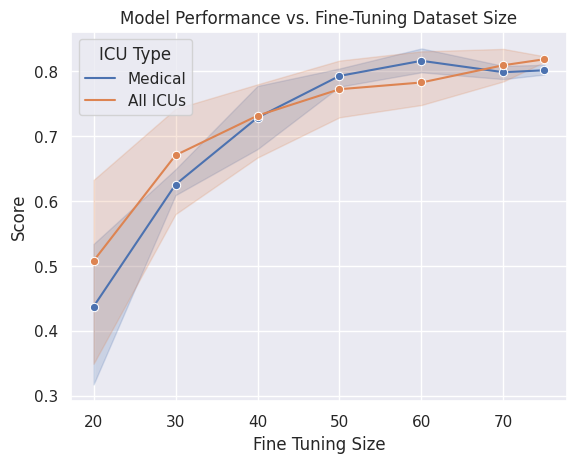

In [43]:
sns.set_theme()

sns.lineplot(
    data=pvft, 
    x="Fine Tuning Size", 
    y="Score", 
    hue="ICU Type", 
    marker='o',
).set(title='Model Performance vs. Fine-Tuning Dataset Size')

# Fixed (n = 1000) vs. Maximum Pretraining Size

In [44]:
fvmp = results_raw[results_raw['Fine Tuning Size'] == ecmo_size].drop(columns=['Fine Tuning Size'])
fixed_pretraining = fvmp[fvmp['Pretraining Size'] == 1000]
max_pretraining = fvmp[fvmp['Pretraining Size'] == 0]

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset')]

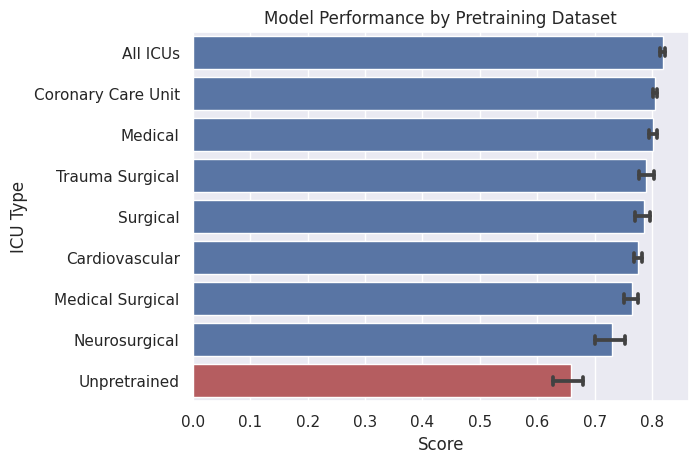

In [45]:
plot_order = max_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=max_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title='Model Performance by Pretraining Dataset')

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)')]

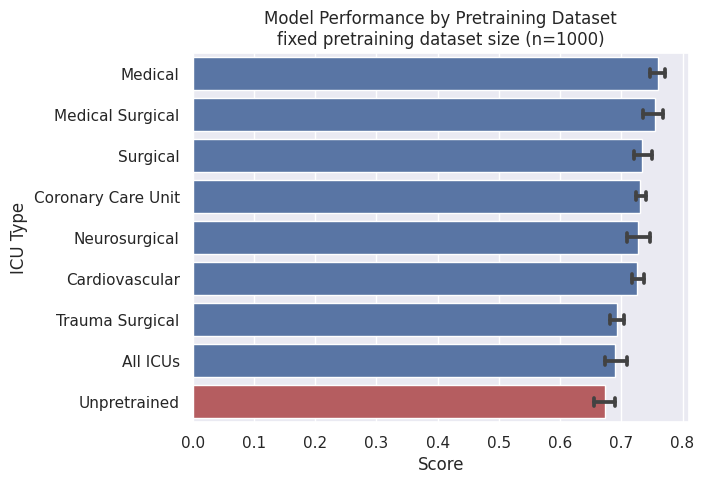

In [46]:
plot_order = fixed_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=fixed_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title="Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)")

# Performance by Pretraining Dataset Size

In [47]:
pvpt = results_raw[(results_raw['Pretraining Size'] != 0) & (results_raw['Pretraining Size'] != 1000)]
pvpt

,ICU Type,Pretraining Size,Fine Tuning Size,Score,Seed,Timestamp
355,All ICUs,8192,75,0.800872,42,2023-12-03 12:09:45.154418
356,All ICUs,8,75,0.664244,42,2023-12-03 12:09:45.154418
357,All ICUs,4096,75,0.755814,42,2023-12-03 12:09:45.154418
358,All ICUs,2048,75,0.745640,42,2023-12-03 12:09:45.154418
359,All ICUs,512,75,0.711483,42,2023-12-03 12:09:45.154418
360,All ICUs,1024,75,0.722384,42,2023-12-03 12:09:45.154418
361,All ICUs,128,75,0.718023,42,2023-12-03 12:09:45.154418
362,All ICUs,64,75,0.686047,42,2023-12-03 12:09:45.154418
363,All ICUs,32,75,0.646802,42,2023-12-03 12:09:45.154418
364,All ICUs,16384,75,0.762355,42,2023-12-03 12:09:45.154418


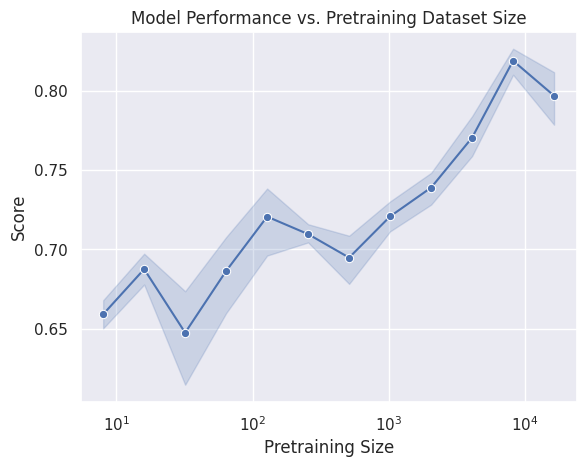

In [48]:
sns.set_theme()

sns.lineplot(
    data=pvpt, 
    x="Pretraining Size", 
    y="Score",
    marker='o',
).set(title='Model Performance vs. Pretraining Dataset Size')
plt.xscale('log')